In [1]:
import numpy as np
import pandas as pd
import glob
import os 
import re
import h5py
import astropy.units as u
from astropy.time import Time
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt 
from hzlc_result import read_output
from hzlc_result import load_data
from hzlc_result import plotter
import importlib


date = 20200124
dir_catalog_star = "/blacksmith/product/out_analysis_%d/catalog_star_header/" % date
dir_light_curve = "/blacksmith/product/out_analysis_%d/light_curve_pca/" % date
#dir_light_curve_pca = "/mnt/storage/out_analysis_aizw01/light_curve_pca"
parquet_dir = "/mnt/tomoe/catalog/gaia/parquet"
num_stars =1

## Take mdwarfs from particular date
df_catalog_target = read_output.take_md_or_wds_for_a_day(dir_catalog_star, str(date), target = "MD")
#df_catalog_target = read_output.take_md_or_wds_for_a_day(dir_catalog_star, str(date), target = "WD")
print("Number of M dwarfs: %d" % (len(df_catalog_target)))

Number of M dwarfs: 730


In [2]:
#plot sky positions of targets
plot_skymap = False
if plot_skymap:
    plotter.plot_skymap_equatorial(df_catalog_target)
    plotter.plot_skymap_galactic(df_catalog_target)

In [3]:
## get source id
source_ids = load_data.get_complete_source_ids(df_catalog_target[:num_stars])


In [4]:

# load light curve
source_ids, list_light_curve = read_output.load_light_curves(source_ids,dir_light_curve,date)

# get lightcurve types
light_curve_keys = list_light_curve[0].keys()
name_of_fluxes = [x for x in light_curve_keys if (x.startswith('flux_') or x.startswith('cflux'))*(not x.endswith('_err'))]
name_of_fluxes = [x for x in name_of_fluxes if not 'detected' in  x] # Not using detected aparture
catalog_import = "/blacksmith/catalog/used_now/ohsawa_+_mdwarf+wd.pickle"
catalog_all = pd.read_pickle(catalog_import)

flux type flux_catalog_aperture_r7
        Unnamed: 0           source_id          ra       dec  catalog_mag  \
447541   3152851.0  658981509446771200  127.717944  16.92336      15.4056   

          Teff       rad      mass catalog_name  is_target  \
447541  3399.0  0.359385  0.345044     Gaia-DR2       True   

        is_Mdwarf_0.3-0.4Msun  is_Mdwarf_less_0.3Msun  
447541                   True                   False  


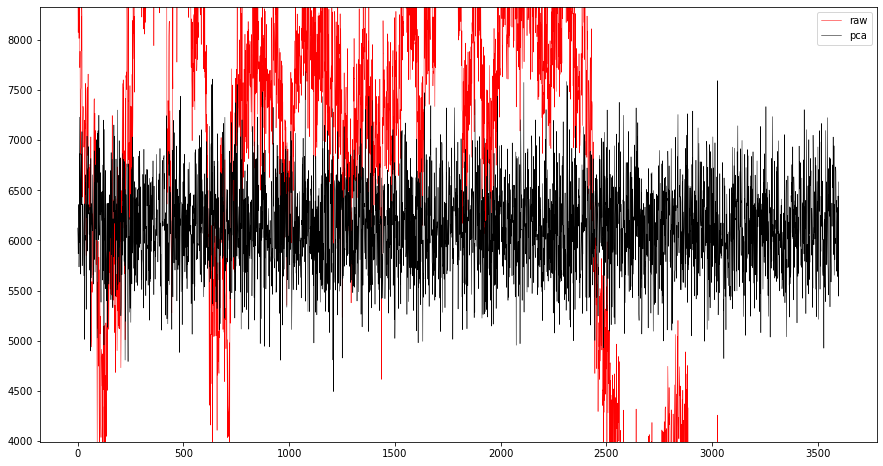

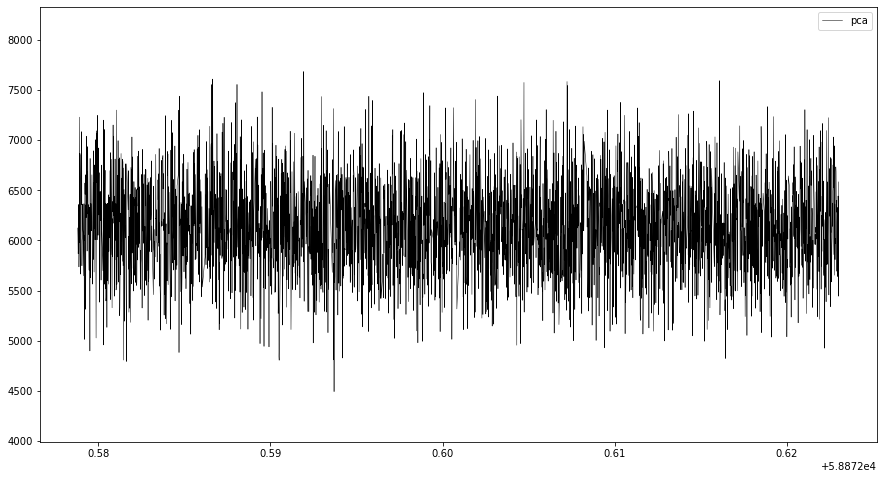

In [5]:
## flux type to plot

plot_flux_name = "flux_catalog_aperture_r7"
butugiri =True

## If this is True, flux type is determined by S/N
if_flux_determine_from_s_n = False 

for i, dmy in enumerate(list_light_curve[:num_stars]):

    
    
    ## Gaia DR2 name
    source_name = source_ids[i].replace("Gaia-DR2_", "")
    source_name = source_name.replace("K2-EPIC_", "")

    #test =  df_catalog_target[df_catalog_target["source_id"]==int(source_name)]["dec"]>40
    #if test.values[0]:
    #    continue
        
    ## flux type determination from S/N
    if if_flux_determine_from_s_n:
        sn_of_fluxes = []
        for ddmy in name_of_fluxes:
            # remove low-quality data
            mask = []
            if ddmy == 'flux_auto':
                mask = (dmy['flag_flux_auto'].astype(bool)) | (dmy['separation_cross_match'] > 1.2e-3)
            elif ddmy == 'flux_iso':
                mask = dmy['flag_sep'].astype(bool) | (dmy['separation_cross_match'] > 1.2e-3)
            elif ddmy == 'cflux':
                mask = dmy['flag_sep'].astype(bool) | (dmy['separation_cross_match'] > 1.2e-3)
            else :
                mask = dmy['flag_'+ddmy.lstrip('flux_')]
            mask = np.logical_not(mask)
            # S/N = mean(flux) / mean(flux_err)
            sn_of_fluxes.append(np.average(dmy[ddmy][mask])/np.average(dmy[ddmy+'_err'][mask]))
        max_sn_index = np.argmax(sn_of_fluxes)
        plot_flux_name = name_of_fluxes[max_sn_index]
   
    

    # remove low-quality data by making mask
    mask = []
    if plot_flux_name == 'flux_auto':
        mask = (dmy['flag_flux_auto'].astype(bool)) | (dmy['separation_cross_match'] > 1.2e-3)
    elif plot_flux_name == 'flux_iso':
        mask = dmy['flag_sep'].astype(bool) | (dmy['separation_cross_match'] > 1.2e-3)
    elif plot_flux_name == 'cflux':
        mask = dmy['flag_sep'].astype(bool) | (dmy['separation_cross_match'] > 1.2e-3)
    else :
        mask = dmy['flag_'+plot_flux_name.lstrip('flux_')]
    mask = np.logical_not(mask)
     
    # we only see m dwarfs < 0.3Msun
    #try:
    flag = catalog_all["source_id"] == int(source_name)
    #if catalog_all[flag]["is_Mdwarf_less_0.3Msun"].values[0] == True:
    #    continue
    print("flux type", plot_flux_name)
    print(catalog_all[flag])
    #except:
    #    pass
    ## load data from data frame
    if (len(dmy["utc_frame"])<100):
        continue
    t = Time(dmy["utc_frame"], format='datetime64', scale='utc')
    times = t.to_value('mjd','long')
    fluxes = dmy[plot_flux_name]
    flux_errs = dmy[plot_flux_name+'_err']
    flux_pca = dmy['pca_'+plot_flux_name]
    times = times[mask]
    fluxes = fluxes[mask]
    flux_errs = flux_errs[mask]
    flux_pca = flux_pca[mask]
    
    ## plot
    try :
        len(fluxes)
        fig = plt.figure(figsize=(15.0, 8.0)) 
        upper_val = np.percentile(flux_pca, [1,99])
        dif_val = upper_val[1] - upper_val[0]

        if butugiri:
            plt.plot(np.arange(len(times)), fluxes, color="r", label="raw", lw = 0.5)  
            plt.plot(np.arange(len(times)), flux_pca, color="k", label="pca", lw = 0.5)  
        else:
            plt.plot(times, fluxes, color="r", label="raw", lw = 0.5)  
            plt.plot(times, flux_pca, color="k", label="pca", lw = 0.5)
            
        plt.ylim(upper_val[0] - dif_val*0.5, upper_val[1] + dif_val*0.5)
        plt.legend()
        plt.show()    
        
        len(fluxes)
        fig = plt.figure(figsize=(15.0, 8.0)) 

        plt.plot(times, flux_pca, color="k", label="pca", lw = 0.5)
        plt.ylim(upper_val[0] - dif_val*0.5, upper_val[1] + dif_val*0.5)
        plt.legend()
        plt.show()           

    except:
        pass